In [9]:
# Standard library imports
import os
import time
import warnings
import sys
import requests


# Third party imports
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.metrics import r2_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from cryptocmd import CmcScraper
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# Local application imports
# Import other necessary libraries and modules here
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, Span, Range1d
from bokeh.layouts import column
from bokeh.models.widgets import Button
from bokeh.models.callbacks import CustomJS
from bokeh.themes import Theme
from math import pi
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.models import HoverTool
from bokeh.models import ColumnDataSource, WheelZoomTool
import pandas as pd


warnings.filterwarnings('ignore')


In [10]:
#!pip install cryptocmd

In [11]:
# Block 1 - load data with CmC Scrapper
class CryptoData:
    """
    This class is responsible for fetching and formatting cryptocurrency data.

    Input:
        crypto_symbol (str): The symbol of the cryptocurrency, e.g., "BTC" for Bitcoin.

    Methods:
        get_cryptocmd_data: Fetches cryptocurrency data and returns a formatted DataFrame.
        get_display_data: Fetches and formats cryptocurrency data for display purposes.
    """
    def __init__(self, crypto_symbol: str):
        self.crypto_symbol = crypto_symbol

    def _fetch_cryptocmd_data(self) -> pd.DataFrame:
        try:
            scraper = CmcScraper(self.crypto_symbol)
            return scraper.get_dataframe()
        except Exception as e:
            print(f'An error occurred while fetching data: {e}')
            return pd.DataFrame()  # Return an empty DataFrame when an error occurs

    def get_cryptocmd_data(self) -> pd.DataFrame:
        df = self._fetch_cryptocmd_data()
        df.set_index('Date', inplace=True)
        df.index = pd.to_datetime(df.index)
        return df.round(2)

    @staticmethod
    def _format_monetary_value(value: float) -> str:
        return "${:,.2f}".format(value)

    @staticmethod
    def _format_volume_value(value: float) -> str:
        return "{:,.2f}".format(value)

    def get_display_data(self) -> pd.DataFrame:
        display_df = self.get_cryptocmd_data().copy()
        monetary_columns = ['Open', 'High', 'Low', 'Close', 'Market Cap']
        display_df[monetary_columns] = display_df[monetary_columns].applymap(self._format_monetary_value)
        display_df['Volume'] = display_df['Volume'].apply(self._format_volume_value)
        return display_df

In [12]:
crypto = CryptoData("BTC")

data = crypto.get_cryptocmd_data()
display_data = crypto.get_display_data()
display_data
data.to_csv('dadada.csv')

In [13]:
class DataPreprocessing:

    def __init__(self, data, targets=[], columns_to_scale=[], random_state=None):
        self.data = data.sort_index(ascending=True)
        self.targets = targets
        self.columns_to_scale = columns_to_scale
        self.random_state = random_state
        self.data_scaled = None  # Initialize the data_scaled attribute

    def missing_values_table(self):
        mis_val = self.data.isnull().sum()
        mis_val_percent = 100 * mis_val / len(self.data)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
            columns={0: 'Missing Values', 1: '% of Total Values'}
        )
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:, 1] != 0
        ].sort_values('% of Total Values', ascending=False).round(1)

        print(
            f"Your selected dataframe has {self.data.shape[1]} columns.\n"
            f"There are {mis_val_table_ren_columns.shape[0]} columns that have missing values."
        )

        return mis_val_table_ren_columns

    def normalize_and_scale(self):
        data_normalized = self.data.copy()
        self.scaler = StandardScaler()
        # Instantiate a separate StandardScaler for the 'Close' prices
        self.close_scaler = StandardScaler()
        data_normalized[self.columns_to_scale] = self.scaler.fit_transform(data_normalized[self.columns_to_scale])
        # Fit the close_scaler on the 'Close' prices
        self.close_scaler.fit(data_normalized[['Close']])
        self.data_scaled = data_normalized
        return self.data_scaled


    def split_data(self, splitter):
        # Ensure that data_normalized has been calculated
        if self.data_scaled is None:
            raise ValueError("Please call 'normalize_and_scale' method before splitting the data.")

        # Calculate the index position to split the data
        split_index = int(len(self.data_scaled) * (1 - splitter))

        # Split the data into train and test sets
        data_train = self.data_scaled.iloc[:split_index]
        data_test = self.data_scaled.iloc[split_index:]

        X_train = data_train.loc[:, data_train.columns != 'Close']
        y_train = data_train.loc[:, 'Close']

        X_test = data_test.loc[:, data_test.columns != 'Close']
        y_test = data_test.loc[:, 'Close']

        # Convert to NumPy array
        y_train= y_train.to_numpy()
        y_test= y_test.to_numpy()
        X_train= X_train.to_numpy()
        X_test= X_test.to_numpy()

        # Reshape to 3D [samples, timesteps, features]
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        return X_train, y_train, X_test, y_test

    def visualize_split(self, train_close, test_close):
        # Restore target values before normalization
        y_train_restored = self.data['Close'][:len(y_train)]
        y_test_restored = self.data['Close'][len(y_train):]

        train_dates = self.data.index[:len(train_close)]
        test_dates = self.data.index[-len(test_close):]

        # Set up Bokeh figure
        p = figure(width=950, height=500, x_axis_type="datetime", title="Training and Testing Data")

        # Add gridlines to the plot
        p.xgrid.grid_line_color = "gray"
        p.ygrid.grid_line_color = "gray"
        p.xgrid.grid_line_alpha = 0.3
        p.ygrid.grid_line_alpha = 0.3

        # Training Data Line
        p.line(train_dates, y_train_restored, color='blue', legend_label='Training Data', line_width=2)

        # Testing Data Line
        p.line(test_dates, y_test_restored, color='orange', legend_label='Testing Data', line_width=2)

        # Add hover tool
        hover = HoverTool(tooltips=[("Date", "@x{%F}"), ("Value", "$@y{0,0.00}")],
                  formatters={"@x": "datetime"})

        p.add_tools(hover)
        p.toolbar.logo = None
        # Show the dynamic line chart
        show(p)

In [14]:
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
preprocessor = DataPreprocessing(data, columns_to_scale=columns_to_scale)
data_normalized = preprocessor.normalize_and_scale()

In [15]:
# Split the data into train and test sets
X_train, y_train, X_test, y_test = preprocessor.split_data(splitter=0.2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2965, 1, 5) (2965,) (742, 1, 5) (742,)


In [16]:
preprocessor.visualize_split(y_train, y_test)

In [33]:
class LSTM_Models:
    def __init__(self, X_train, y_train, X_test, y_test, model):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = model

    def train_model(self, epochs=100, batch_size=50):
        self.history = self.model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size, verbose=2,validation_data=(self.X_test, self.y_test), shuffle=False)

    def make_predictions(self, close_scaler):
        # Make predictions on the normalized data
        train_predict = self.model.predict(self.X_train)
        test_predict = self.model.predict(self.X_test)
        # Invert predictions to get them on the same scale as the original data
        train_predict = close_scaler.inverse_transform(train_predict)
        y_train_rescaled = close_scaler.inverse_transform([self.y_train])
        test_predict = close_scaler.inverse_transform(test_predict)
        y_test_rescaled = close_scaler.inverse_transform([self.y_test])
        # Create a DataFrame to compare actual vs predicted values for the training data
        train_comparison_df = pd.DataFrame({
            'Actual': y_train_rescaled[0],
            'Predict': train_predict[:,0]
        })
        # Create a DataFrame to compare actual vs predicted values for the testing data
        test_comparison_df = pd.DataFrame({
            'Actual': y_test_rescaled[0],
            'Predict': test_predict[:,0]
        })

        return train_comparison_df, test_comparison_df

    def plot_history(self):
        plt.figure(figsize=(14, 7))
        # Plot the loss
        plt.plot(self.history.history['loss'], label='Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        # Add title and labels
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        # Show the plot
        plt.show()

        from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


    def evaluate_model(self, train_comparison_df, test_comparison_df):
        # Calculate metrics for the training data
        train_rmse = mean_squared_error(train_comparison_df['Actual'], train_comparison_df['Predict'], squared=False)
        train_mae = mean_absolute_error(train_comparison_df['Actual'], train_comparison_df['Predict'])
        train_mse = mean_squared_error(train_comparison_df['Actual'], train_comparison_df['Predict'])
        train_r2 = r2_score(train_comparison_df['Actual'], train_comparison_df['Predict'])
        # Calculate metrics for the testing data
        test_rmse = mean_squared_error(test_comparison_df['Actual'], test_comparison_df['Predict'], squared=False)
        test_mae = mean_absolute_error(test_comparison_df['Actual'], test_comparison_df['Predict'])
        test_mse = mean_squared_error(test_comparison_df['Actual'], test_comparison_df['Predict'])
        test_r2 = r2_score(test_comparison_df['Actual'], test_comparison_df['Predict'])
        # Create a DataFrame to hold the results
        results_df = pd.DataFrame({
            'Metric': ['RMSE', 'MAE', 'MSE', 'R2'],
            'Train': [train_rmse, train_mae, train_mse, train_r2],
            'Test': [test_rmse, test_mae, test_mse, test_r2]
        })

        return results_df

    def plot_predictions(self, train_comparison_df, test_comparison_df):
        plt.figure(figsize=(14, 7))
        # Plot the actual and predicted values for the training data
        plt.subplot(1, 2, 1)
        plt.plot(train_comparison_df['Actual'], label='Actual')
        plt.plot(train_comparison_df['Predict'], label='Predict')
        plt.title('Training Data: Actual vs Predicted')
        plt.legend()
        # Plot the actual and predicted values for the testing data
        plt.subplot(1, 2, 2)
        plt.plot(test_comparison_df['Actual'], label='Actual')
        plt.plot(test_comparison_df['Predict'], label='Predict')
        plt.title('Testing Data: Actual vs Predicted')
        plt.legend()
        # Show the plot
        plt.show()


model1 = Sequential()
model1.add(LSTM(120, activation="tanh", input_shape=(1, 5)))
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')

# Define model 2
model2 = Sequential()
model2 = Sequential()
model2.add(LSTM(120, activation="tanh", input_shape=(1, 5)))
model2.add(Dropout(0.2))
model2.add(Dense(5))
model2.compile(loss='mean_squared_error', optimizer='adam')

# Define model 3
model3 = Sequential()
model3.add(LSTM(120, activation="tanh", input_shape=(1, 5)))
model3.add(Dropout(0.2))
model3.add(Dense(20))
model3.compile(loss='mean_squared_error', optimizer='adam')


# Define model 4
model4 = Sequential()
model4.add(LSTM(120, activation="tanh", input_shape=(1, 5)))
model4.add(Dropout(0.2))
model4.add(Dense(100))
model4.compile(loss='mean_squared_error', optimizer='adam')


# Define model 5
model5 = Sequential()
model5.add(LSTM(120, activation="tanh", input_shape=(1, 5)))
model5.add(Dropout(0.2))
model5.add(Dense(250))
model5.compile(loss='mean_squared_error', optimizer='adam')


# Define model 6
model6 = Sequential()
model6.add(LSTM(120, activation="tanh", input_shape=(1, 5)))
model6.add(Dropout(0.2))
model6.add(Dense(2000))
model6.compile(loss='mean_squared_error', optimizer='adam')

# Define model 6
model7 = Sequential()
model7.add(LSTM(120, activation="tanh", input_shape=(1, 5)))
model7.add(Dropout(0.2))
model7.add(Dense(4.5))
model7.compile(loss='mean_squared_error', optimizer='adam')


In [34]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# Initialize and train the LSTM model 1
lstm_1 = LSTM_Models(X_train, y_train, X_test, y_test, model1)
lstm_1.train_model(epochs=100, batch_size=50)
train_comparison_df,test_comparison_df = lstm_1.make_predictions(preprocessor.close_scaler)

# Initialize and train the LSTM model 2
lstm_2 = LSTM_Models(X_train, y_train, X_test, y_test, model2)
lstm_2.train_model(epochs=100, batch_size=50)
train_comparison_df,test_comparison_df = lstm_1.make_predictions(preprocessor.close_scaler)

# Initialize and train the LSTM model 3
lstm_3 = LSTM_Models(X_train, y_train, X_test, y_test, model3)
lstm_3.train_model(epochs=100, batch_size=50)
train_comparison_df,test_comparison_df = lstm_3.make_predictions(preprocessor.close_scaler)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# Initialize and train the LSTM model 2
lstm_4 = LSTM_Models(X_train, y_train, X_test, y_test, model4)
lstm_4.train_model(epochs=100, batch_size=50)
train_comparison_df,test_comparison_df = lstm_4.make_predictions(preprocessor.close_scaler)

# Initialize and train the LSTM model 2
lstm_5 = LSTM_Models(X_train, y_train, X_test, y_test, model5)
lstm_5.train_model(epochs=100, batch_size=50)
train_comparison_df,test_comparison_df = lstm_5.make_predictions(preprocessor.close_scaler)

# Initialize and train the LSTM model 2
lstm_6 = LSTM_Models(X_train, y_train, X_test, y_test, model6)
lstm_6.train_model(epochs=100, batch_size=50)
train_comparison_df,test_comparison_df = lstm_6.make_predictions(preprocessor.close_scaler)

# Initialize and train the LSTM model 2
lstm_7 = LSTM_Models(X_train, y_train, X_test, y_test, model6)
lstm_7.train_model(epochs=100, batch_size=50)
train_comparison_df,test_comparison_df = lstm_7.make_predictions(preprocessor.close_scaler)

(2965, 1, 5) (2965,) (742, 1, 5) (742,)
Epoch 1/100
60/60 - 4s - loss: 0.2492 - val_loss: 0.8554 - 4s/epoch - 67ms/step
Epoch 2/100
60/60 - 0s - loss: 0.0533 - val_loss: 0.2835 - 354ms/epoch - 6ms/step
Epoch 3/100
60/60 - 0s - loss: 0.0176 - val_loss: 0.0664 - 441ms/epoch - 7ms/step
Epoch 4/100
60/60 - 0s - loss: 0.0095 - val_loss: 0.0292 - 377ms/epoch - 6ms/step
Epoch 5/100
60/60 - 1s - loss: 0.0057 - val_loss: 0.0196 - 503ms/epoch - 8ms/step
Epoch 6/100
60/60 - 1s - loss: 0.0042 - val_loss: 0.0107 - 503ms/epoch - 8ms/step
Epoch 7/100
60/60 - 0s - loss: 0.0037 - val_loss: 0.0082 - 428ms/epoch - 7ms/step
Epoch 8/100
60/60 - 0s - loss: 0.0036 - val_loss: 0.0062 - 486ms/epoch - 8ms/step
Epoch 9/100
60/60 - 0s - loss: 0.0052 - val_loss: 0.0076 - 437ms/epoch - 7ms/step
Epoch 10/100
60/60 - 0s - loss: 0.0050 - val_loss: 0.0050 - 333ms/epoch - 6ms/step
Epoch 11/100
60/60 - 0s - loss: 0.0098 - val_loss: 0.0110 - 325ms/epoch - 5ms/step
Epoch 12/100
60/60 - 0s - loss: 0.0118 - val_loss: 0.0048 

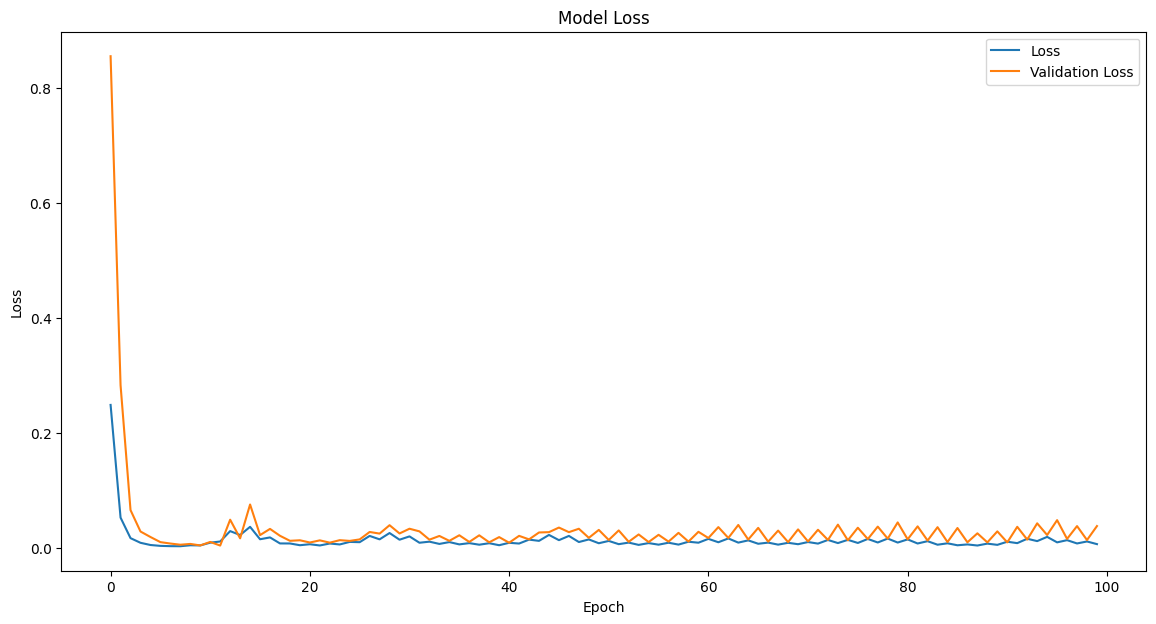

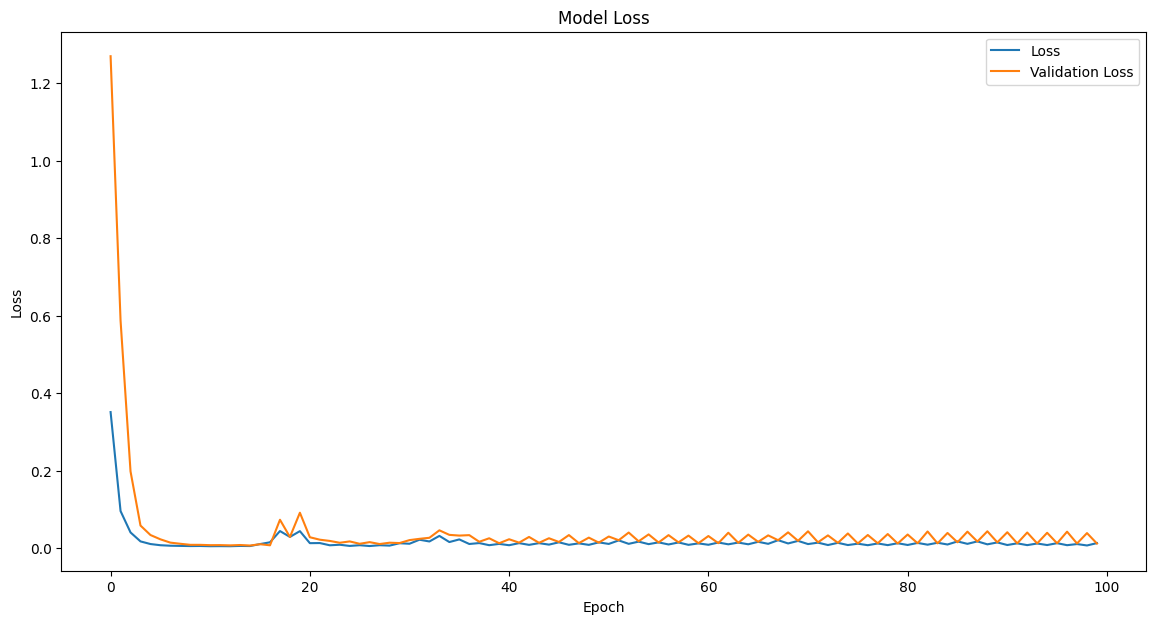

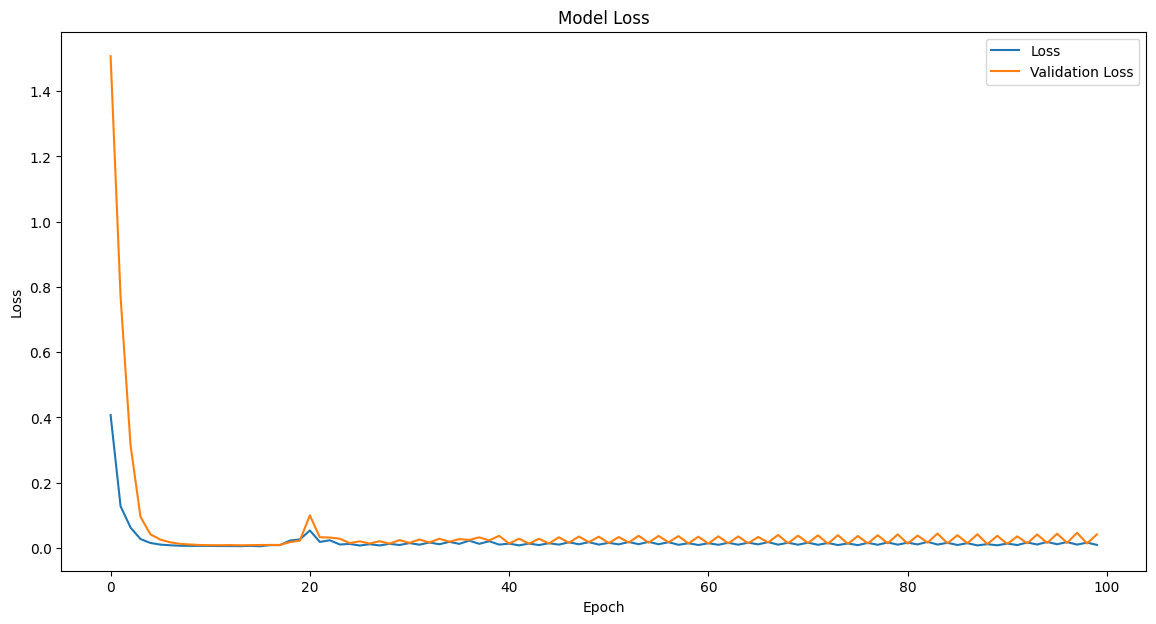

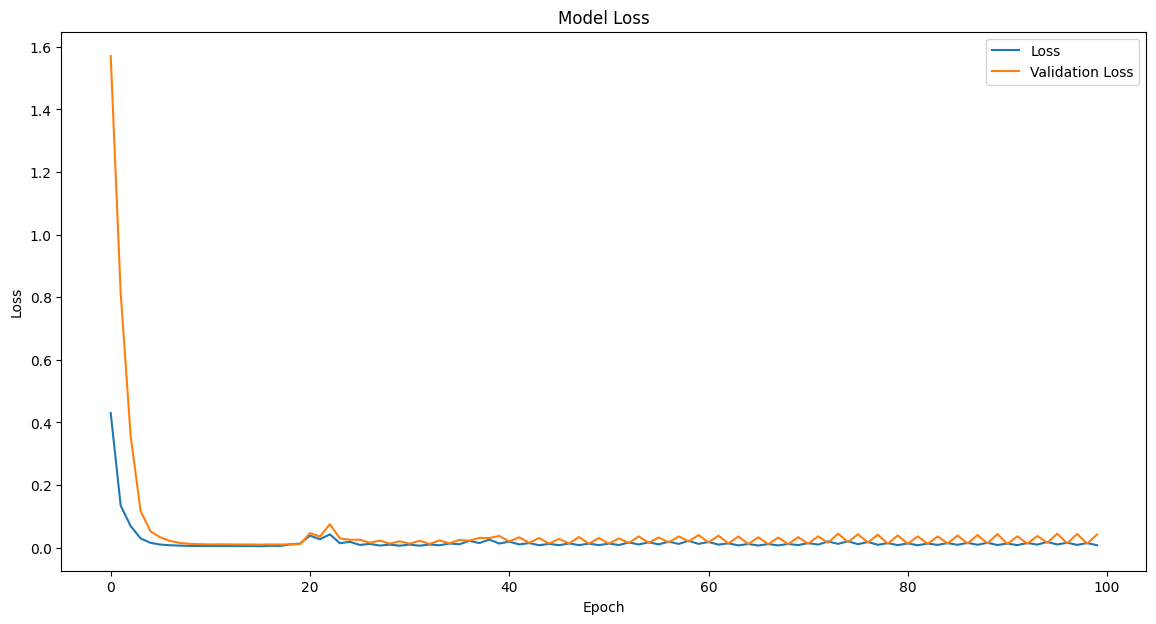

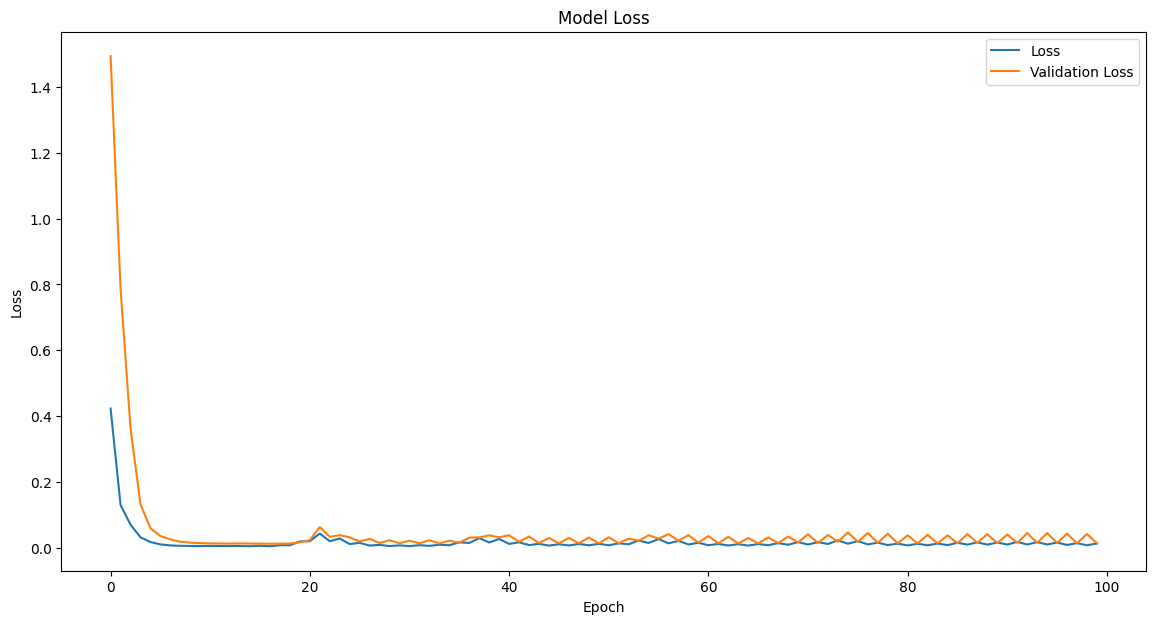

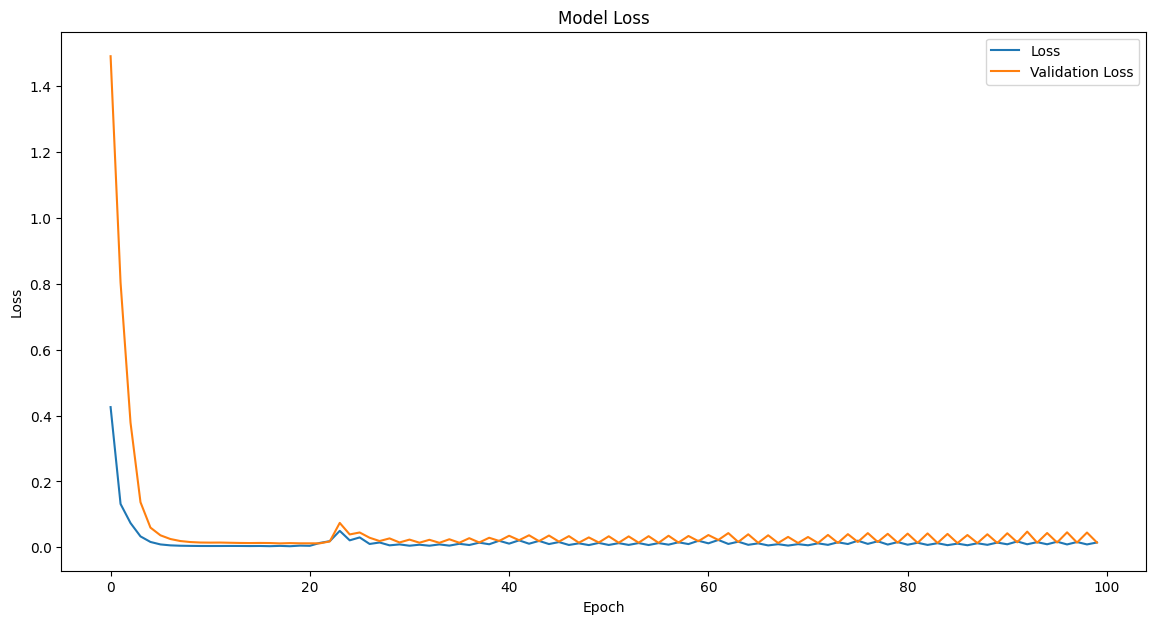

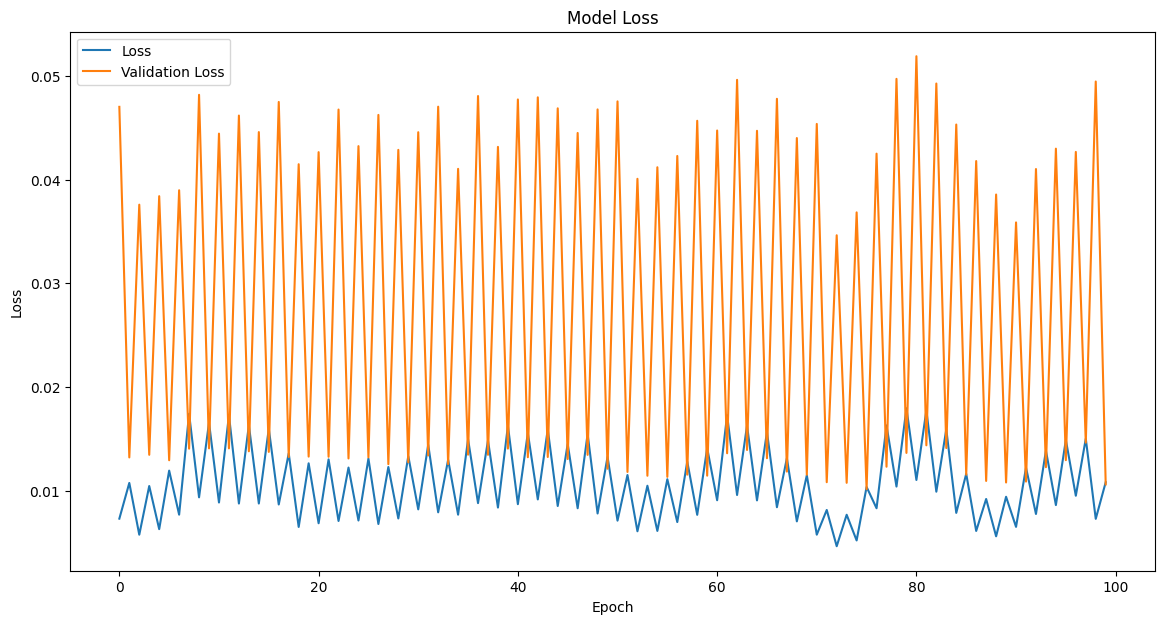

In [35]:
lstm_1.plot_history()
lstm_2.plot_history()
lstm_3.plot_history()
lstm_4.plot_history()
lstm_5.plot_history()
lstm_6.plot_history()
lstm_7.plot_history()


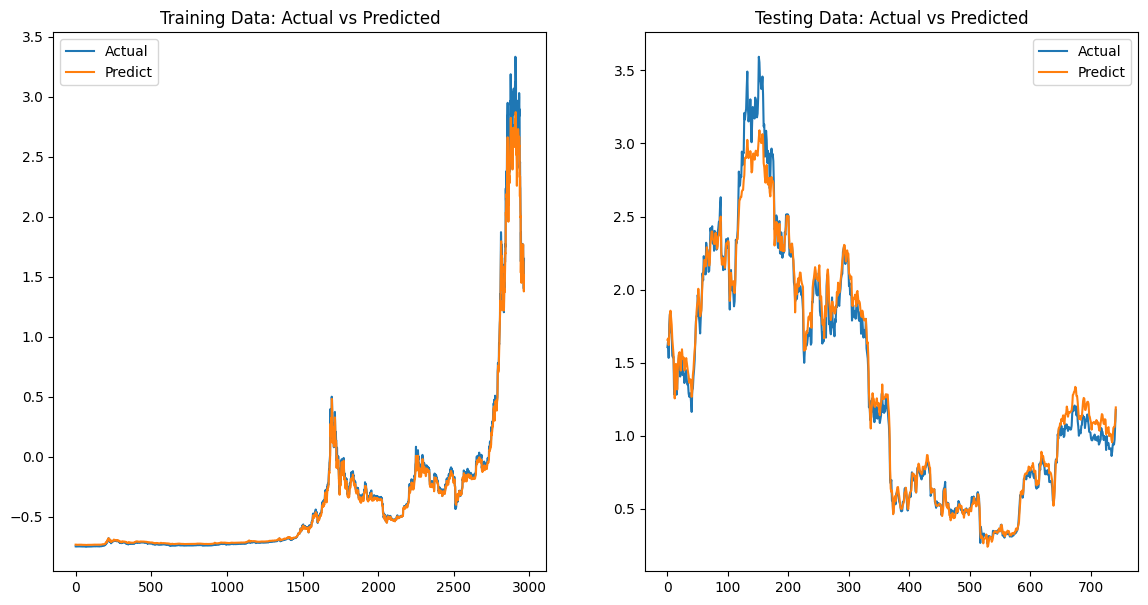

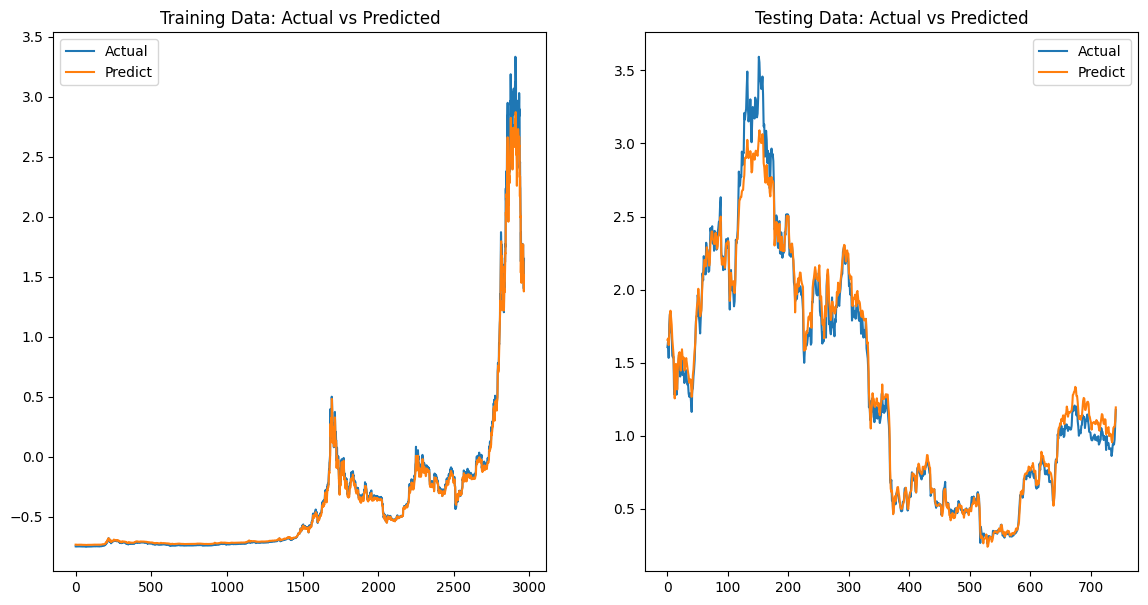

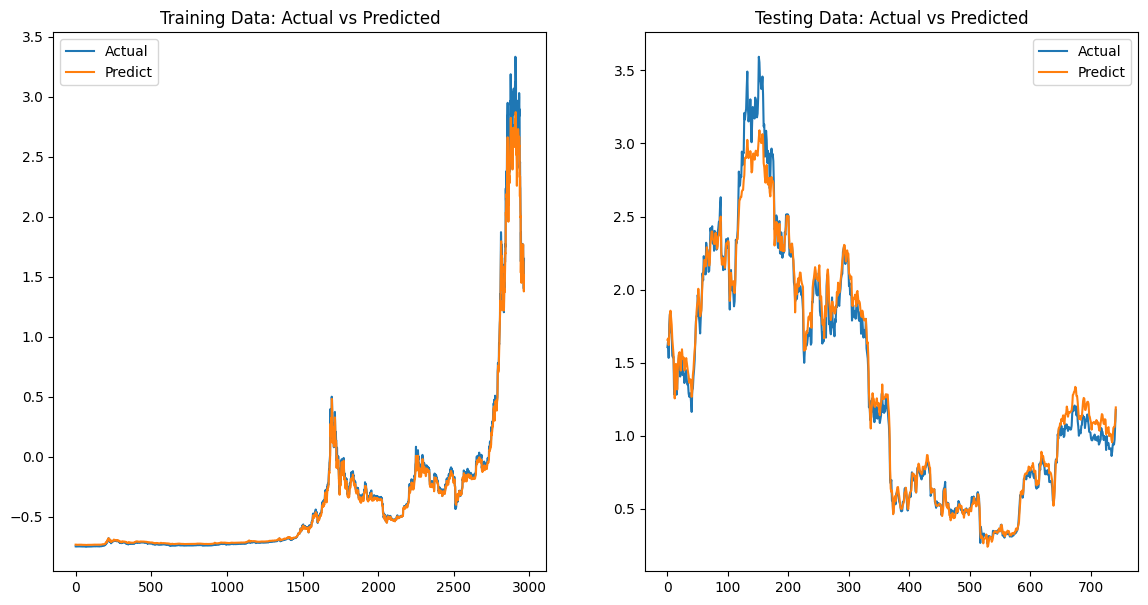

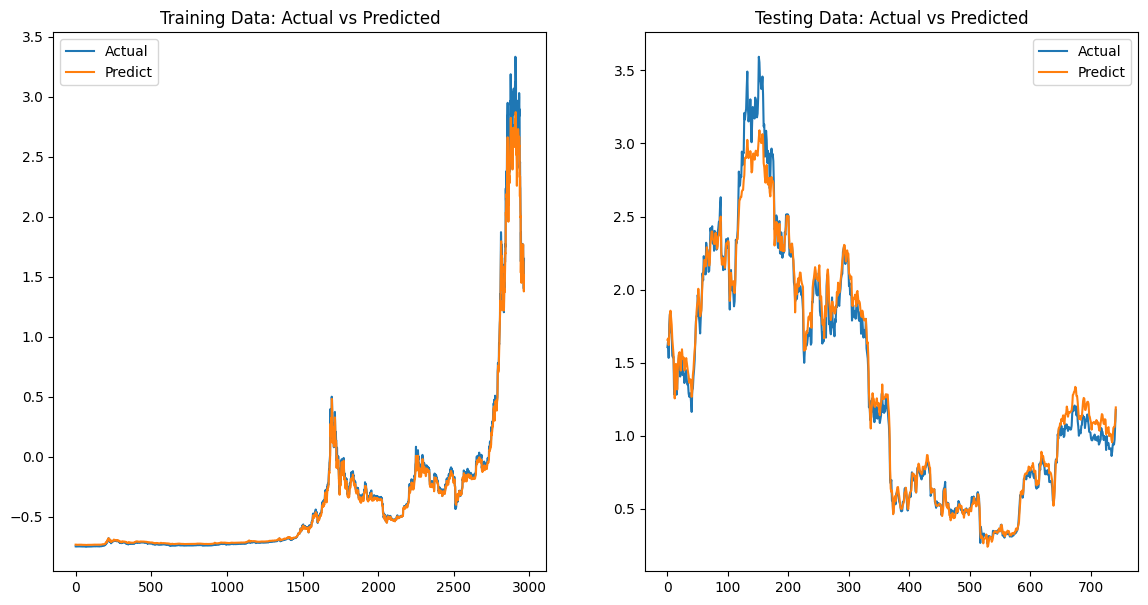

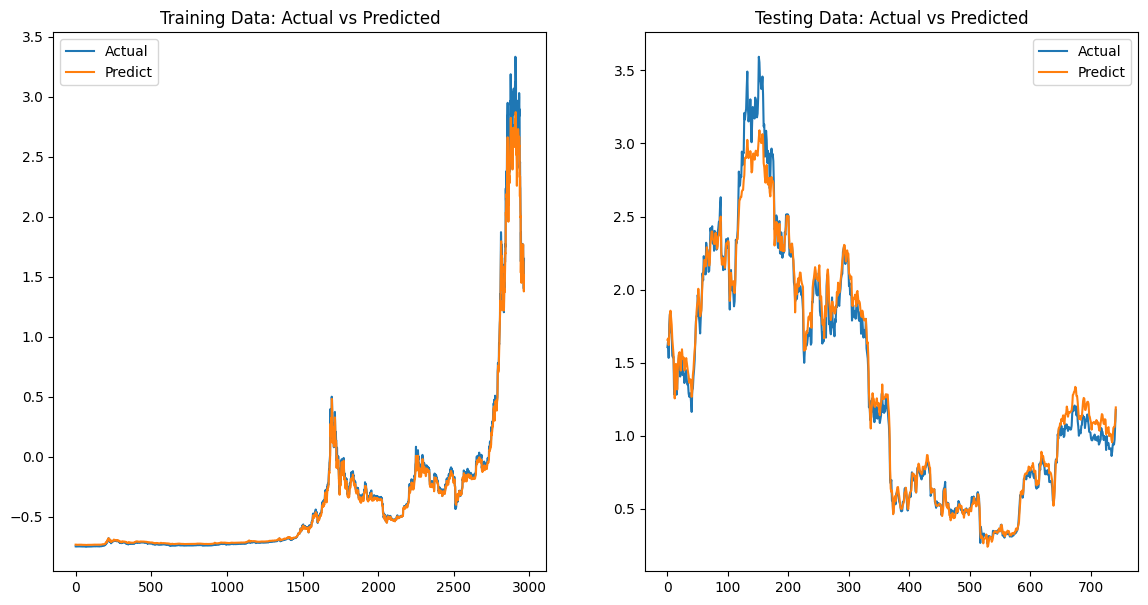

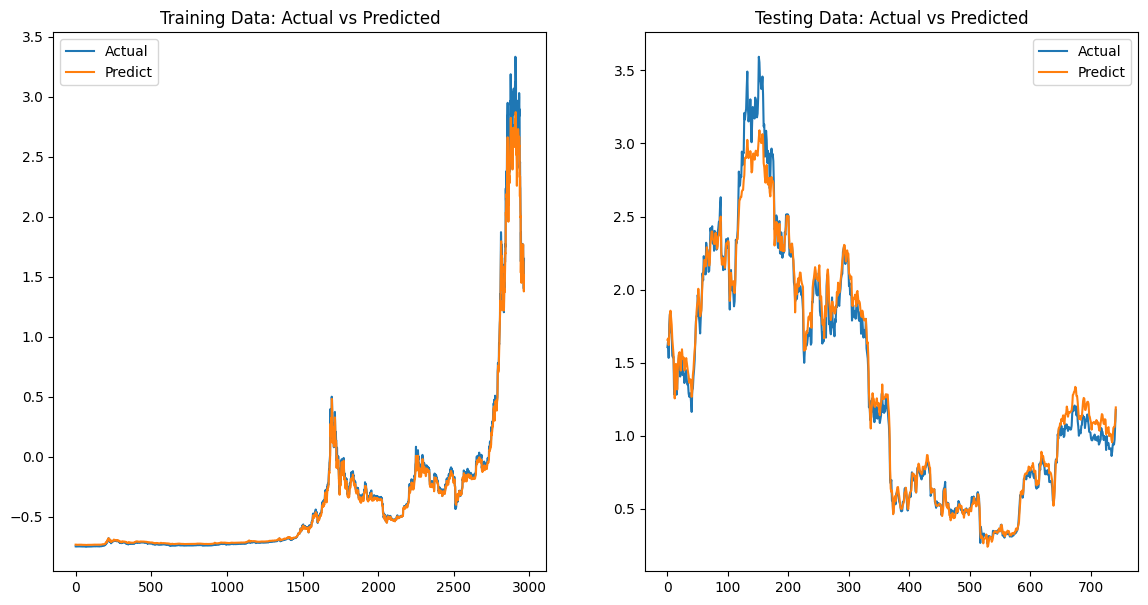

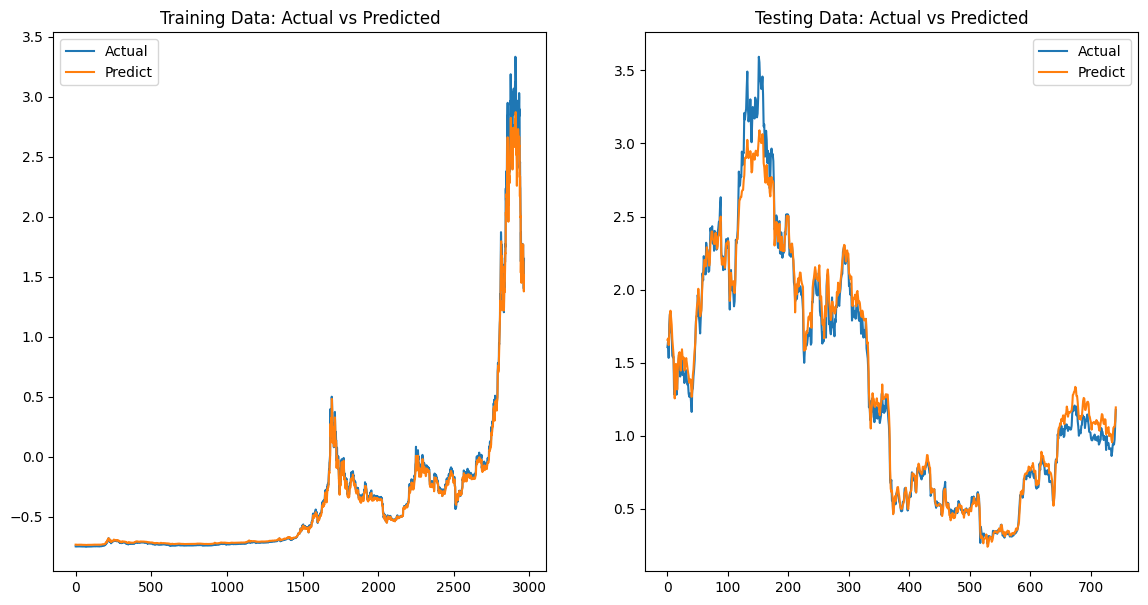

In [36]:
lstm_1.plot_predictions(train_comparison_df, test_comparison_df)
lstm_2.plot_predictions(train_comparison_df, test_comparison_df)
lstm_3.plot_predictions(train_comparison_df, test_comparison_df)
lstm_4.plot_predictions(train_comparison_df, test_comparison_df)
lstm_5.plot_predictions(train_comparison_df, test_comparison_df)
lstm_6.plot_predictions(train_comparison_df, test_comparison_df)
lstm_7.plot_predictions(train_comparison_df, test_comparison_df)

In [26]:
results_df1 = lstm_1.evaluate_model(train_comparison_df1, test_comparison_df1)
results_df2 = lstm_2.evaluate_model(train_comparison_df2, test_comparison_df2)
results_df3 = lstm_3.evaluate_model(train_comparison_df3, test_comparison_df3)
#results_df4 = lstm_4.evaluate_model(train_comparison_df, test_comparison_df)

print(results_df1, results_df2, results_df3)

  Metric     Train      Test
0   RMSE  0.049498  0.192974
1    MAE  0.036889  0.174560
2    MSE  0.002450  0.037239
3     R2  0.995118  0.945196   Metric     Train      Test
0   RMSE  0.049498  0.192974
1    MAE  0.036889  0.174560
2    MSE  0.002450  0.037239
3     R2  0.995118  0.945196   Metric     Train      Test
0   RMSE  0.048602  0.189319
1    MAE  0.036586  0.170550
2    MSE  0.002362  0.035842
3     R2  0.995293  0.947252


In [37]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Define a function that creates a model, required for KerasClassifier
def create_model(dropout_rate=0.0, dense_units=1, optimizer='adam'):
    print(f"Model run, dropout_rate = {dropout_rate}, dense_units = {dense_units}, optimizer = {optimizer}")
    model = Sequential()
    model.add(LSTM(120, activation="tanh", input_shape=(1, 5)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Wrap our Keras model in an estimator compatible with scikit_learn
model = KerasRegressor(build_fn=create_model, verbose=0)

param_grid = {
    'batch_size': [256],
    'epochs': [100],
    'dropout_rate': [0.1],
    'dense_units': [1, 4, 5, 10, 25, 50, 100],
    'optimizer': ['Adam']
}

In [38]:
# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, scoring='r2')
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam


Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam


Model run, dropout_rate = 0.1, dense_units = 4, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 4, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 4, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 4, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 4, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 5, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 5, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 5, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 5, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 5, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 10, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 10, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 10, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 10, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 10, optimizer = Adam
Model run, dropout_r

In [41]:
param_grid = {
    'batch_size': [256],
    'epochs': [100],
    'dropout_rate': [0.1],
    'dense_units': [0.1, 1, 2],
    'optimizer': ['Adam']
}

In [42]:
# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, scoring='r2')
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Model run, dropout_rate = 0.1, dense_units = 0.1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 0.1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 0.1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 0.1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 0.1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 2, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 2, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 2, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 2, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 2, optimizer = Adam
Model run, drop

In [45]:
param_grid = {
    'batch_size': [32, 64, 100, 128],
    'epochs': [50],
    'dropout_rate': [0.1],
    'dense_units': [1],
    'optimizer': ['Adam']
}

In [46]:
# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, scoring='r2')
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate =

In [47]:
param_grid = {
    'batch_size': [100],
    'epochs': [50,100,200],
    'dropout_rate': [0.1],
    'dense_units': [1],
    'optimizer': ['Adam']
}

In [48]:
# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, scoring='r2')
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate =

In [51]:
param_grid = {
    'batch_size': [100],
    'epochs': [50],
    'dropout_rate': [0.1,0.2,0.3,0.5],
    'dense_units': [1],
    'optimizer': ['Adam']
}

In [52]:
# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, scoring='r2')
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.1, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.2, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.2, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.2, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.2, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.2, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.3, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.3, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.3, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.3, dense_units = 1, optimizer = Adam
Model run, dropout_rate = 0.3, dense_units = 1, optimizer = Adam
Model run, dropout_rate =